# Classification Network

The goal here is to classify whether the error rate is "low" "medium" or "high".
If we can successfully do this, then look at whether we can get the sign right. Start off by using the squeezenet model.

### Todos:
- [x] Add dense layer
- [x] Abstract images file
- [x] Write a models file 
- [ ] high resolution flow
- [ ] try adding flow and raw images


In [22]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading vector data
Loading image data
Preprocessing data
Input shape:  (9400, 48, 64, 2)


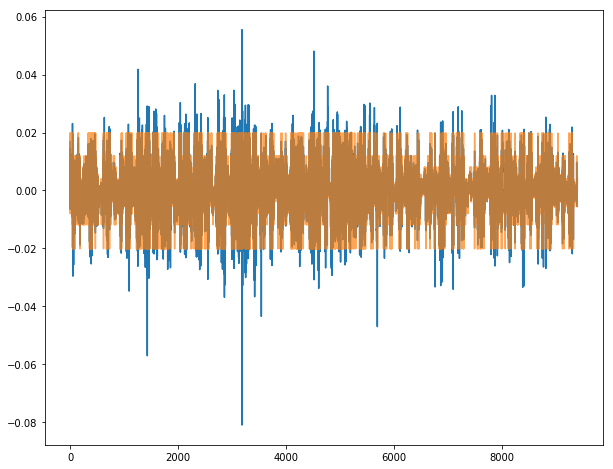

In [46]:
BATCH_SIZE = 512
NUM_CLASSES = 16
TRAIN_RATIO = 0.6

import utilities
# Datafile options:
imu_data,x_data,y_norm = utilities.load_data('/media/Big_Data/stefantj/flows_lowres_16k.npy')
#imu_data,flows_data,y_norm = utilities.load_data('../gbucket/center_cropped_300x300.npy')
#imu_data,x_data,y_norm = utilities.load_data('../gbucket/center_cropped_192x192.npy')

# Split into training/val data:
N_training = int(TRAIN_RATIO*x_data.shape[0])
N_validation = x_data.shape[0]- N_training

y_data, mean_vals = utilities.discretize_outputs(y_norm[0:N_training], NUM_CLASSES)
y_data, tmp = utilities.discretize_outputs(y_norm, NUM_CLASSES)

x_train = x_data[0:N_training,...]
y_train = y_data[0:N_training]

x_val = x_data[N_training:,...]
y_val = y_data[N_training:]

print('Input shape: ', x_data.shape)

# Plot the discretization with perfect classification:
plt.plot(y_norm)
plt.plot(mean_vals[y_data.astype(np.int32)],alpha=0.7)



In [47]:
from classifiers.squeezenet import SqueezeNet

with tf.device('/gpu:0'):
    tf.reset_default_graph() # remove all existing variables in the graph 
    sess = get_session() # start a new Session

    # Load the model:
    model = SqueezeNet(NUM_CLASSES, x_data.shape[3], x_data.shape[1])
    # If you want a pretrained model, pass save_path as an argument. 
    # Since pretrained weights didn't do well, let's skip them. 
    # SAVE_PATH = 'classifiers/squeezenet.ckpt'

    # Slow way to initialize variables that is robust to partially loaded models:
    uninitialized_vars = []
    for var in tf.global_variables():
        try:
            sess.run(var)
        except tf.errors.FailedPreconditionError:
            uninitialized_vars.append(var)

    init = tf.variables_initializer(uninitialized_vars)
    sess.run(init)

    saver = tf.train.Saver()
#    saver.restore(sess, './checkpoints/good_run') # Assumes N_classes = 128, batch_size = 64
#    saver.restore(sess, tf.train.latest_checkpoint('.'))

(9400, 48, 64, 2)
Step:  0  Train Acc:  0.0555556  Val Acc:  0.0 loss 2.75554 LR:  0.000784


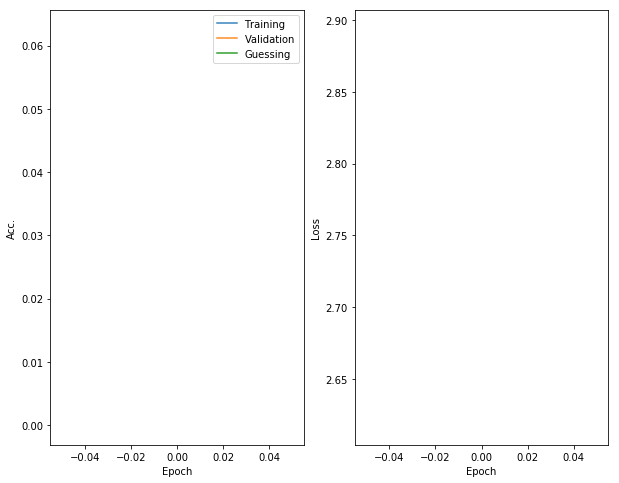

RMSE:  0.00921259583243
Ratio to zero-prediction:  1.10394550064
('plotting from ', 0, ' to ', 9400)
High correlation (near 1) means we are predicting well.
('Correlation between error and signal:', 0.0064162035528280096)


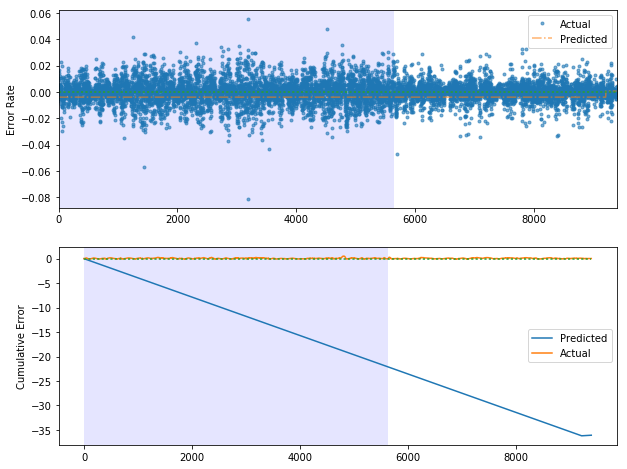

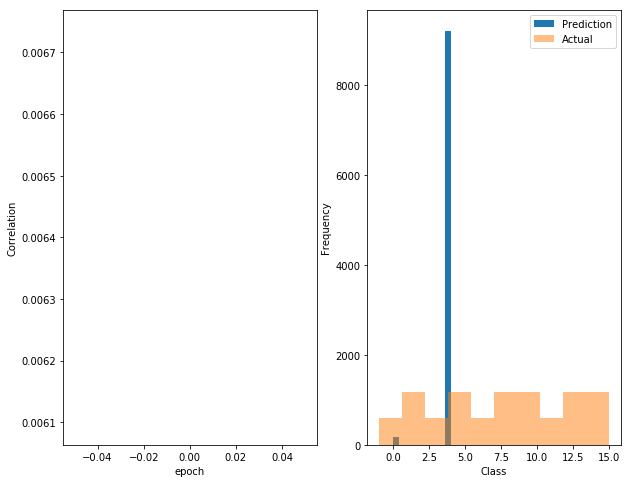

Step:  1000  Train Acc:  0.074028426394  Val Acc:  0.0307692 loss 2.75735046988 LR:  0.000737894528


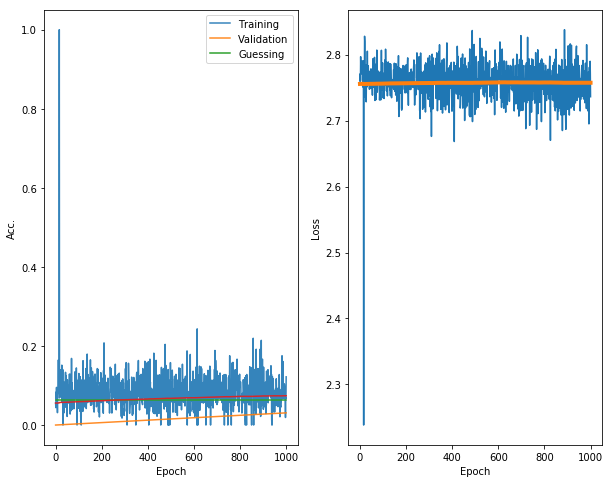

RMSE:  0.0180093258172
Ratio to zero-prediction:  2.15805779033
('plotting from ', 0, ' to ', 9400)
High correlation (near 1) means we are predicting well.
('Correlation between error and signal:', 0.031692180831455224)


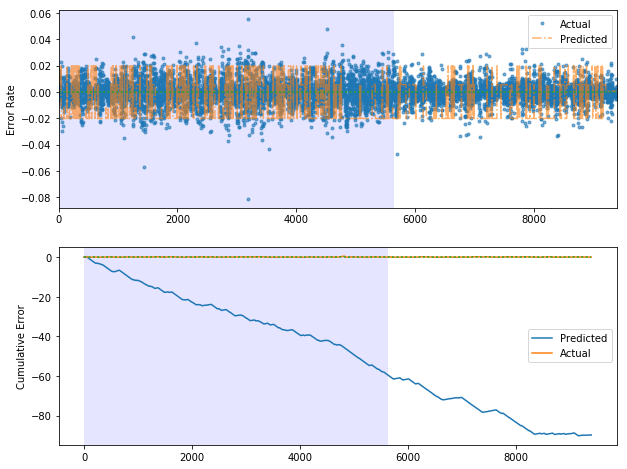

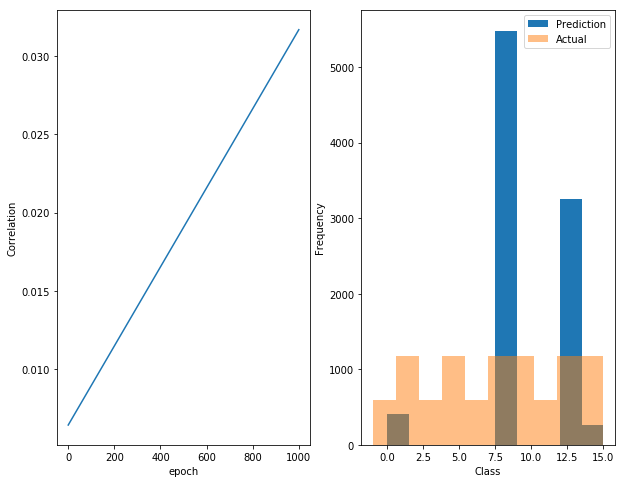

Step:  2000  Train Acc:  0.0838910311744  Val Acc:  0.0352941 loss 2.75467048128 LR:  0.000694500426597


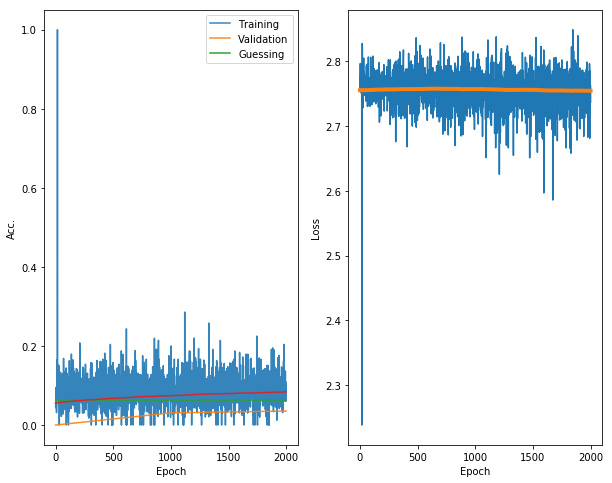

RMSE:  0.0197508569319
Ratio to zero-prediction:  2.36674549066
('plotting from ', 0, ' to ', 9400)
High correlation (near 1) means we are predicting well.
('Correlation between error and signal:', 0.043831111616352454)


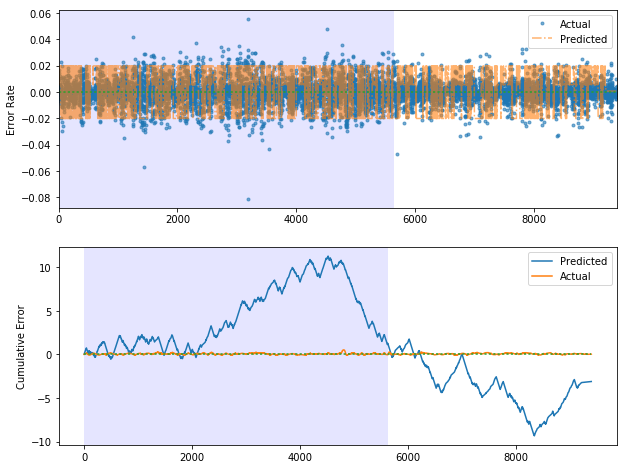

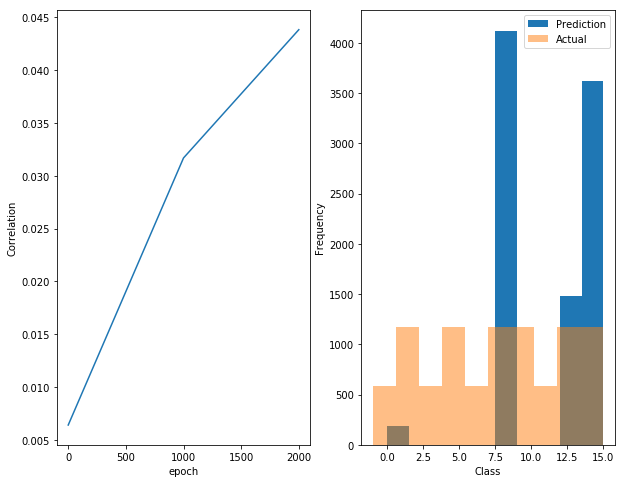

Step:  3000  Train Acc:  0.0919617961714  Val Acc:  0.0416667 loss 2.75090903418 LR:  0.0006405850806


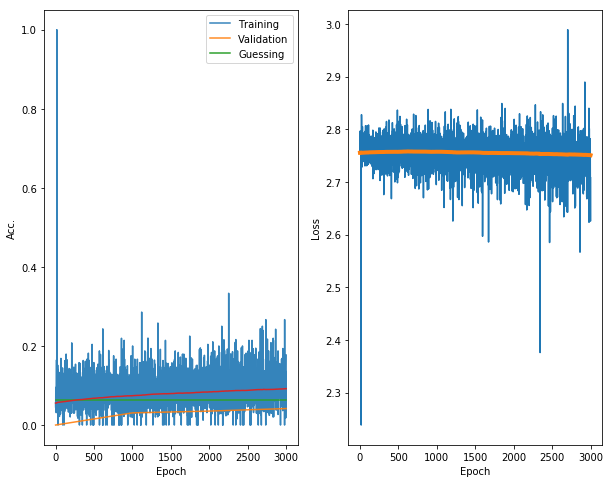

RMSE:  0.0193480012201
Ratio to zero-prediction:  2.31847128451
('plotting from ', 0, ' to ', 9400)
High correlation (near 1) means we are predicting well.
('Correlation between error and signal:', 0.040079701069995949)


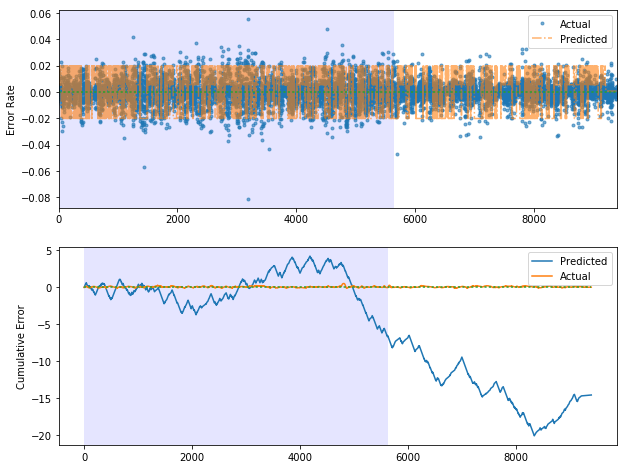

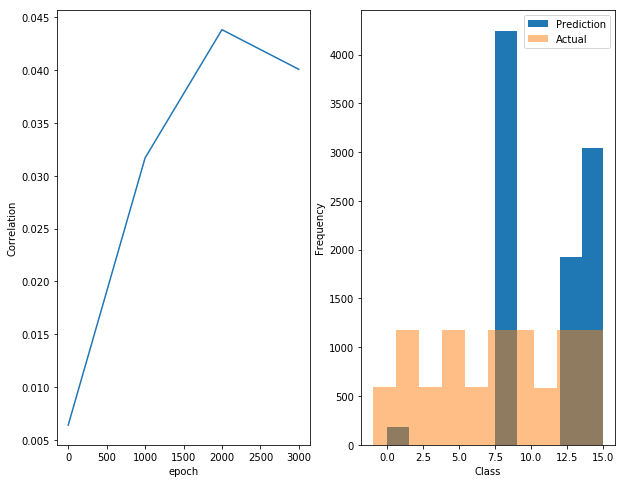

Step:  4000  Train Acc:  0.0954654564599  Val Acc:  0.03125 loss 2.74757029891 LR:  0.00060291355318


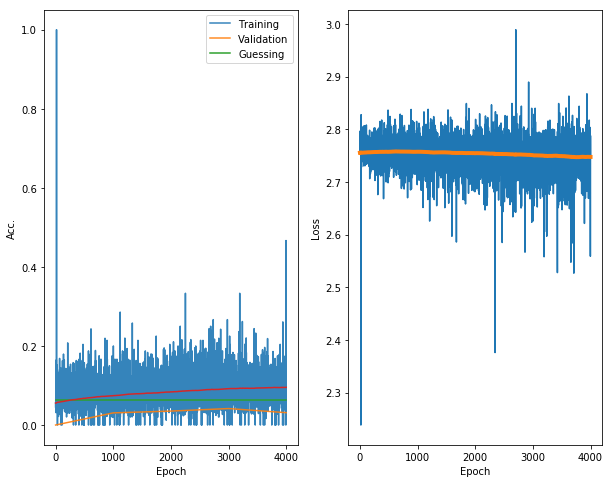

RMSE:  0.0173521820834
Ratio to zero-prediction:  2.07931224659
('plotting from ', 0, ' to ', 9400)
High correlation (near 1) means we are predicting well.
('Correlation between error and signal:', 0.042973708042923914)


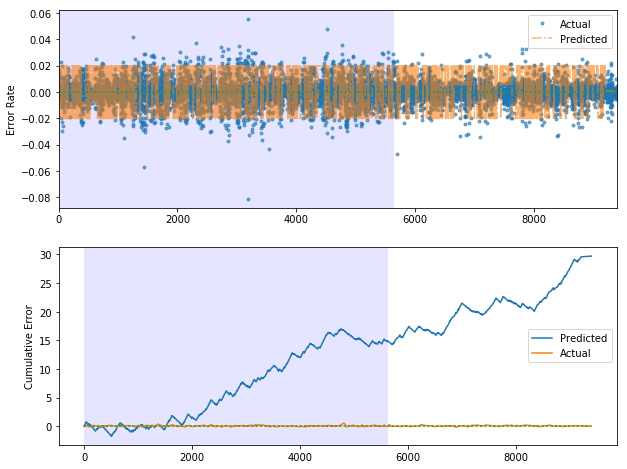

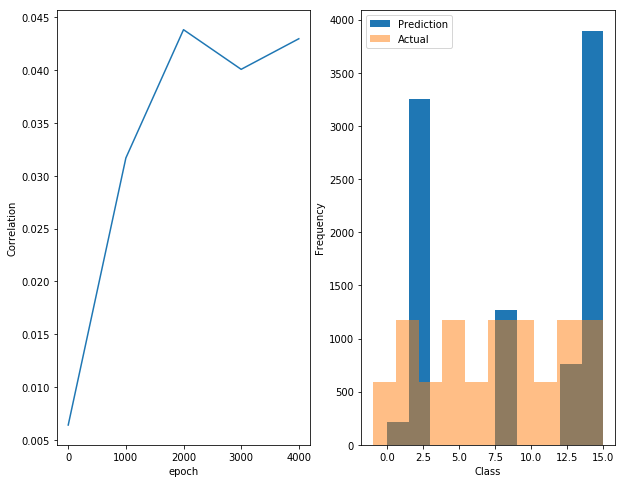

Step:  5000  Train Acc:  0.100135605621  Val Acc:  0.0714286 loss 2.74344332517 LR:  0.000567457412945


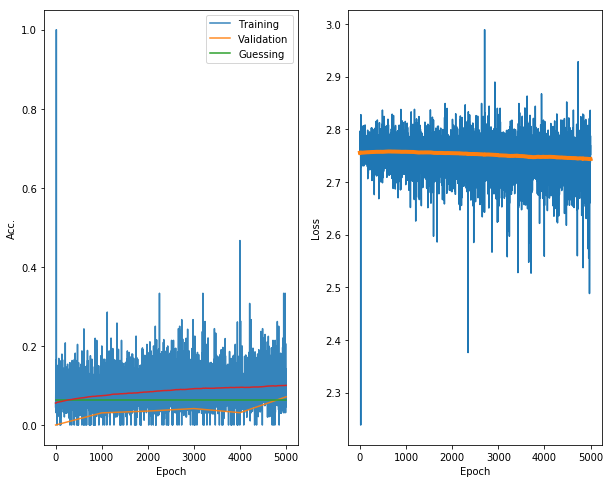

RMSE:  0.0138337920215
Ratio to zero-prediction:  1.65770351123
('plotting from ', 0, ' to ', 9400)
High correlation (near 1) means we are predicting well.
('Correlation between error and signal:', 0.045255376352993149)


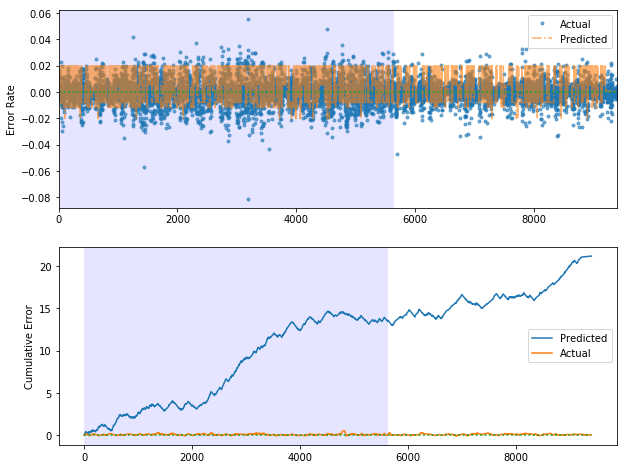

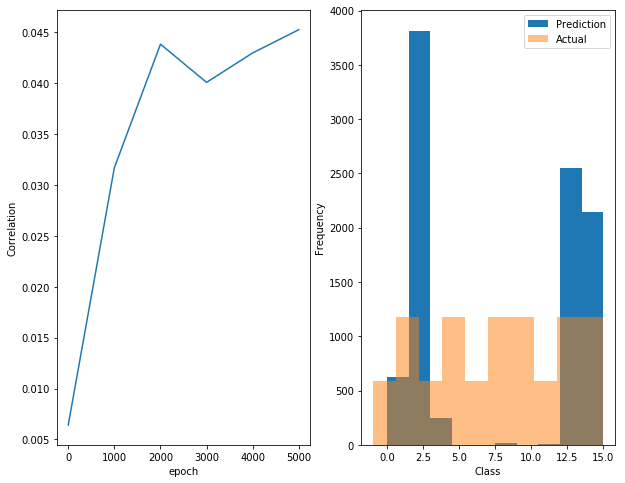

In [ ]:
print(x_data.shape)
# simple parameters:
disp_period = 1000
training_iters = 40000
lr = 0.0008 # 0.0002 is a good value for 20 bins
lr_decay = 0.98

# Launch the graph
step = 1 
history = {'train_acc': [], 'train_loss': [], 's_tacc': [], 's_tloss': [], 'val_inds': [], 'val_acc':[], 'corr':[]}
smooth_val = 0.999

for step in range(training_iters):
    if step % 300 is 0:
        lr *= lr_decay
        saver.save(sess, 'classification_model', global_step = step)
    batch_x, batch_y = utilities.sample_seqbatch(BATCH_SIZE,1, x_train, y_train)
    o,loss,acc = sess.run([model.optimizer,model.loss, model.acc], feed_dict={model.image: batch_x, model.labels: batch_y, model.lr:[lr]})

    history["train_acc"].append(acc)
    history["train_loss"].append(loss)
    if(step is 0):
        history["s_tloss"].append(loss)
        history["s_tacc"].append(acc)
    else:
        history["s_tloss"].append(smooth_val*history["s_tloss"][-1] + (1-smooth_val)*loss)
        history["s_tacc"].append(smooth_val*history["s_tacc"][-1] + (1-smooth_val)*acc)

    if step % disp_period is 0:
        # Calculate val accuracy:
        batch_x, batch_y = utilities.sample_seqbatch(BATCH_SIZE,1, x_val, y_val)
        acc_v = sess.run(model.acc, feed_dict={model.image: batch_x, model.labels: batch_y})
        history["val_acc"].append(acc_v)
        history["val_inds"].append(step)

        print('Step: ', step, ' Train Acc: ', history["s_tacc"][-1], ' Val Acc: ', history["val_acc"][-1], 'loss', history["s_tloss"][-1], 'LR: ', lr)
        plt.subplot(1,2,1)
        plt.plot(history["train_acc"],alpha=0.9)
        plt.plot(history["val_inds"], history["val_acc"],alpha=0.9)
        plt.plot([0,step], [1/float(NUM_CLASSES),1/float(NUM_CLASSES)])
        plt.legend(['Training','Validation','Guessing'])
        plt.plot(history["s_tacc"])
        plt.xlabel('Epoch')
        plt.ylabel('Acc.')
        plt.subplot(1,2,2)
        plt.plot(history["train_loss"])
        plt.plot(history["s_tloss"], linewidth=4)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Prediction is cheap for this:
        y_pred = np.zeros_like(y_data)
        for k in range(0,x_data.shape[0]-(x_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
            imgs = x_data[k:k+BATCH_SIZE,:,:]
            pred = sess.run(model.prediction, feed_dict={model.image: imgs, model.labels: y_norm[k:k+BATCH_SIZE]})
            y_pred[k:k+BATCH_SIZE] = pred
        prediction = mean_vals[(y_pred).astype(np.int32)];
        # hack:
        i_zero = np.where(prediction==0)
        prediction[i_zero] = 0
        # end hack
        print('RMSE: ', utilities.calc_rmse(prediction, y_norm))
        print('Ratio to zero-prediction: ', utilities.calc_rmse(prediction, y_norm)/utilities.calc_rmse(y_norm, np.zeros_like(y_norm)))
        c = utilities.plot_data(0,y_data.shape[0], prediction, y_norm, x_train.shape[0])
        history["corr"].append(c)
        
        plt.subplot(1,2,1)
        plt.plot(history["val_inds"], history["corr"])
        plt.ylabel('Correlation')
        plt.xlabel('epoch')
        
        plt.subplot(1,2,2)
        plt.hist(y_pred)
        plt.hist(y_data,alpha=0.5)
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.legend(['Prediction', 'Actual'])
        plt.show()

    # Compute sequence prediction:
print('Done.')


In [ ]:
# Reconstruct signal using a randomwalk model:
print('Computing sequence prediction - this may take a while. ')
y_pred = np.zeros_like(y_data)

for k in range(0,flows_data.shape[0]-(flows_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
    if k % 1000 is 0:
        print('k = ', k)
    pred = sess.run(model.prediction, feed_dict={model.image: flows_data[k:k+BATCH_SIZE,:,:,:], model.labels: y_data[k:k+BATCH_SIZE]})
    y_pred[k:k+BATCH_SIZE] = pred
    


In [ ]:
# Can load a previously computed prediction - useful if cold starting a notebook.
r = mean_vals[(y_pred[:]).astype(np.int32)];
np.save('cnn_predictions',r)

y_norm = pos_err_rate

print('RMSE: ',utilities.calc_rmse(r, y_norm))

# smooth the reconstructed signal:
#r = np.zeros_like(reconstructed_signal)
#alpha = 1.0
#for k in range(reconstructed_signal.shape[0]):
#    if(k==0):
#        r[k] = reconstructed_signal[0]
#    else:
#        r[k] = alpha*reconstructed_signal[k] + (1-alpha)*r[k-1]
        
plt.plot(y_norm)
plt.plot(training_data_indices, r[training_data_indices],'.')
plt.plot(validation_data_indices, r[validation_data_indices],'.')
plt.legend(['Actual','Train','Val'])
plt.show()

#plt.title('Learning Curve')
#naive_val = 0
#for k in range(y_data.shape[0]):
#    naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
#naive_val /= y_data.shape[0]

#plt.plot(train_history,'.',alpha=0.3)
#plt.plot(val_history,'.',alpha=0.3)
#plt.plot(naive_val*np.ones_like(train_history),':')
#plt.legend(['Training','Validation','Naive'])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.show()


plot_data(0,y_data.shape[0])
plot_error(300,500)


In [ ]:
plt.plot(mean_vals[(y_pred[:]).astype(np.int32)])
print(y_pred.shape)

In [ ]:
    
    n_disc
    true_disc, mv = utilities.discretize_outputs(y_data, n_disc)
    
    
    plt.subplot(2,1,1);
    plt.plot(pos_err)
    plt.plot()
    plt.subplot(2,1,2)
#    plt.plot(y_data)
#    plt.plot(mean_vals[true_disc.astype(np.int32)],'o',alpha=0.3)
    plt.plot(mean_vals[y_pred.astype(np.int32)],'x',alpha=0.9)
#    plt.ylim([-0.02,0.02])
    plt.xlim([60000,70000])
    plt.show()
    plt.plot(d_raw[:,4],'.')
    plt.xlim([60000,70000])
    plt.show()
    
        
    plt.plot(mean_vals)
    plt.show()
